# RBM as a Quantum Wave Function Ansatz

In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

    96% |██████████████████████████████▉ | 570.7MB 48.8MB/s eta 0:00:01    100% |████████████████████████████████| 592.3MB 45.3MB/s 


In [0]:
from __future__ import division
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## Variational Monte Carlo
With RBM as a state ansatz, we need to train its parameters in order to make it have maximum overlap with the ground state wave function of a hamiltonian.

Notice that the cost function now is the energy rather than the log-likelihood with some known dataset:
$$E_\theta=\frac{\langle\psi_\theta|H|\psi_\theta\rangle}{\langle\psi_\theta|\psi_\theta\rangle}$$
Here, $\theta$ represents parameters in a RBM.

We use Variational Monte Carlo (VMC) method to get the energy expectation and gradients to optimize the ansatz.
VMC states that the gradient of $E$ with respect to $\theta$ is defined as 
$$g=\langle E_{\rm loc}\Delta_{\rm loc}\rangle- \langle E_{\rm loc}\rangle\langle\Delta_{\rm loc}\rangle$$
where $\langle\cdot\rangle$ is the ensemble average over Monte Carlo importance sampling $x\sim|\psi_\theta(x)|^2$, $E_{\rm loc}=\frac{\langle x|H|\psi_\theta\rangle}{\langle x|\psi_\theta\rangle}$, $\Delta_{\rm loc}\equiv\frac{\partial\log\psi_\theta(x)}{\partial \theta}$.

### VMC measurements
1. obtain some samples using `vim_sample` method.
2. perform measurements on samples.


VMC gives expectation values for $\langle E_{\rm loc}\rangle$, $\langle\Delta_{\rm loc}\rangle$ and $\langle E_{\rm loc}\Delta_{\rm loc}\rangle$.
It requires a kernel with following methods
* **propose_config**: propose a new configuration, given old configuration.
* **prob**: give probability for a spin configuration $\langle\sigma|\psi\rangle$.

In [0]:
def vmc_sample(kernel, initial_config, num_bath, num_sample):
    '''
    obtain a set of samples.

    Args:
        kernel (object): defines how to sample, requiring the following methods:
            * propose_config, propose a new configuration.
            * prob, get the probability of specific distribution.
        initial_config (1darray): initial configuration.
        num_bath (int): number of updates to thermalize.
        num_sample (int): number of samples.

    Return:
        list: a list of spin configurations.
    '''
    print_step = num_sample // 5

    config = initial_config
    prob = kernel.prob(config)

    n_accepted = 0
    sample_list = []
    for i in range(num_bath + num_sample):
        # generate new config and calculate probability ratio
        config_proposed = kernel.propose_config(config)
        prob_proposed = kernel.prob(config_proposed)

        # accept/reject a move by metropolis algorithm (world's most famous single line algorithm)
        if np.random.random() < prob_proposed / prob:
            config = config_proposed
            prob = prob_proposed
            n_accepted += 1

        # print statistics
        if i % print_step == print_step - 1:
            print('%-10s Accept rate: %.3f' %
                  (i + 1, n_accepted * 1. / print_step))
            n_accepted = 0

        # add a sample
        if i >= num_bath:
            sample_list.append(config_proposed)
    return sample_list


def vmc_measure(local_measure, sample_list, measure_step, num_bin=50):
    '''
    perform measurements on samples

    Args:
        local_measure (func): local measurements function, input configuration, return local energy and local gradient.
        sample_list (list): a list of spin configurations.
        num_bin (int): number of bins in binning statistics.
        meaure_step: number of samples skiped between two measurements + 1.

    Returns:
        tuple: expectation valued of energy, gradient, energy*gradient and error of energy.
    '''
    # measurements
    energy_loc_list, grad_loc_list = [], []
    for i, config in enumerate(sample_list):
        if i % measure_step == 0:
            # back-propagation is used to get gradients.
            energy_loc, grad_loc = local_measure(config)
            energy_loc_list.append(energy_loc)
            grad_loc_list.append(grad_loc)

    # binning statistics for energy
    energy_loc_list = np.array(energy_loc_list)
    energy, energy_precision = binning_statistics(energy_loc_list, num_bin=num_bin)

    # get expectation values
    energy_loc_list = torch.from_numpy(energy_loc_list)
    if grad_loc_list[0][0].is_cuda: energy_loc_list = energy_loc_list.cuda()
    grad_mean = []
    energy_grad = []
    for grad_loc in zip(*grad_loc_list):
        grad_loc = torch.stack(grad_loc, 0)
        grad_mean.append(grad_loc.mean(0))
        energy_grad.append(
            (energy_loc_list[(slice(None),) + (None,) * (grad_loc.dim() - 1)] * grad_loc).mean(0))
    return energy.item(), grad_mean, energy_grad, energy_precision



def binning_statistics(var_list, num_bin):
    '''
    binning statistics for variable list.
    '''
    num_sample = len(var_list)
    if num_sample % num_bin != 0:
        raise
    size_bin = num_sample // num_bin

    # mean, variance
    mean = np.mean(var_list, axis=0)
    variance = np.var(var_list, axis=0)

    # binned variance and autocorrelation time.
    variance_binned = np.var(
        [np.mean(var_list[size_bin * i:size_bin * (i + 1)]) for i in range(num_bin)])
    t_auto = 0.5 * size_bin * \
        np.abs(np.mean(variance_binned) / np.mean(variance))
    stderr = np.sqrt(variance_binned / num_bin)
    print('Binning Statistics: Energy = %.4f +- %.4f, Auto correlation Time = %.4f' %
          (mean, stderr, t_auto))
    return mean, stderr

### VMC Kernel definition
When proposing a new configuration, it has 5% probability to flip all spin, can making VMC sample better in Heisenberg model, proposed configuration satisfies spin conservation.


In [0]:
class VMCKernel(object):
    '''
    variational monte carlo kernel.

    Attributes:
        energy_loc (func): local energy <x|H|\psi>/<x|\psi>.
        ansatz (Module): torch neural network.
    '''
    def __init__(self, energy_loc, ansatz):
        self.ansatz = ansatz
        self.energy_loc = energy_loc

    def psi(self, config):
        '''
        query the wavefunction.

        Args:
            config (1darray): the bit string as a configuration.

        Returns:
            Variable: the projection of wave function on config, i.e. <config|psi>.
        '''
        psi = self.ansatz.prob_visible(torch.from_numpy(config))
        return psi

    def prob(self, config):
        '''
        probability of configuration.

        Args:
            config (1darray): the bit string as a configuration.

        Returns:
            number: probability |<config|psi>|^2.
        '''
        return abs(self.psi(config).data[0])**2

    def local_measure(self, config):
        '''
        get local quantities energy_loc, grad_loc.

        Args:
            config (1darray): the bit string as a configuration.

        Returns:
            number, list: local energy and local gradients for variables.
        '''
        psi_loc = self.psi(config)

        # get gradients {d/dW}_{loc}
        self.ansatz.zero_grad()
        psi_loc.backward()
        grad_loc = [p.grad.data/psi_loc.data[0] for p in self.ansatz.parameters()]

        # E_{loc}
        eloc = self.energy_loc(config, lambda x: self.psi(x).data, psi_loc.data)[0]
        return eloc, grad_loc

    @staticmethod
    def propose_config(old_config, prob_flip=0.05):
        '''
        flip two positions as suggested spin flips.

        Args:
            old_config (1darray): spin configuration, which is a [-1,1] string.
            prob_flip (float): the probability to flip all spins, to make VMC more statble in Heisenberg model.

        Returns:
            1darray: new spin configuration.
        '''
        # take ~ 5% probability to flip all spin, can making VMC sample better in Heisenberg model
        if np.random.random() < prob_flip:
            return -old_config

        num_spin = len(old_config)
        upmask = old_config == 1
        flips = np.random.randint(0, num_spin // 2, 2)
        iflip0 = np.where(upmask)[0][flips[0]]
        iflip1 = np.where(~upmask)[0][flips[1]]

        config = old_config.copy()
        config[iflip0] = -1
        config[iflip1] = 1
        return config

## Wave function ansatz
Comparing with the model defined in last example, we make serveral adaptions here
* using {-1, 1} valued nodes instead of {0, 1} valued nodes.
* use probability function of visual nodes directly, $p(v)\sim e^{x^T a}\prod\limits_i2\cosh(W_ix+b_i)$.

In [0]:

class RBM(nn.Module):
    '''
    Restricted Boltzmann Machine

    Args:
        num_visible (int): number of visible nodes.
        num_hidden (int): number of hidden nodes.

    Attributes:
        W (2darray): weights.
        v_bias (1darray): bias for visible layer.
        h_bias (1darray): bias for hidden layer.
    '''

    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(num_hidden, num_visible).double() * 1e-1)
        self.v_bias = nn.Parameter(torch.zeros(num_visible).double())
        self.h_bias = nn.Parameter(torch.randn(num_hidden).double() * 1e-1)
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        
    def prob_visible(self, v):
        '''
        probability for visible nodes, visible/hidden nodes here take value in {-1, 1}.

        Args:
            v (1darray): visible input.

        Return:
            float: the probability of v.
        '''
        v = Variable(v.double())
        if self.W.is_cuda: v = v.cuda()
        return (2 * (self.W.mv(v) + self.h_bias).cosh()).prod() * (self.v_bias.dot(v)).exp()

## Hamiltonian
Here, we use the Heisenberg model with rotated basis
$$H=\sum\limits_i J_z S_i^zS_{i+1}^z-\frac{J_{xy}}{2}(S^+_{i}S^-_{i+1}+S^-_{i}S^+_{i+1})$$
Comparing with traditional Heisenberg model, we performed transformation $S^{x,y}_i=-S^{x,y}_i,i\in \rm odd$, intended to make the ground state wave function always positive.

Instead of defining the hamiltonian directlt, we define a function to calculate $E_{\rm loc}$

In [0]:
def heisenberg_loc(config, psi_func, psi_loc, J=1.):
    '''
    local energy for 1D Periodic Heisenberg chain.

    Args:
        config (1darray): bit string as spin configuration.
        psi_func (func): wave function.
        psi_loc (number): wave function projected on configuration <config|psi>.
        J (float): coupling strengh. Here, J = Jxy = Jz.

    Returns:
        number: local energy.
    '''
    # get weights and flips after applying hamiltonian \sum_i w_i|x_i> = H|x>
    nsite = len(config)
    wl, flips = [], []
    # J*SzSz terms.
    nn_par = np.roll(config, -1) * config
    wl.append(J / 4. * (nn_par).sum(axis=-1).item())
    flips.append(np.array([], dtype='int64'))

    # J*SxSx and J*SySy terms.
    mask = nn_par != 1
    i = np.where(mask)[0]
    j = (i + 1) % nsite
    wl += [-J / 2.] * len(i)
    flips.extend(zip(i, j))

    # calculate local energy <\psi|H|x>/<\psi|x>
    acc = 0.
    for wi, flip in zip(wl, flips):
        config_i = config.copy()
        config_i[list(flip)] *= -1
        eng_i = wi * (psi_func(config_i) / psi_loc)
        acc += eng_i
    return acc

## The training

In [0]:
def train(model, learning_rate, use_cuda):
    '''
    train a model.

    Args:
        model (obj): a model that meet VMC model definition.
        learning_rate (float): the learning rate for SGD.
    '''
    initial_config = np.array([-1, 1] * (model.ansatz.num_visible // 2))
    if use_cuda:
        model.ansatz.cuda()

    while True:
        # get expectation values for energy, gradient and their product,
        # as well as the precision of energy.        
        sample_list = vmc_sample(model, initial_config, num_bath=200, num_sample=4000)
        energy, grad, energy_grad, precision = vmc_measure(model.local_measure, sample_list, num_spin)

        # update variables using steepest gradient descent
        g_list = [eg - energy * g for eg, g in zip(energy_grad, grad)]
        for var, g in zip(model.ansatz.parameters(), g_list):
            delta = learning_rate * g
            var.data -= delta
        yield energy, precision

### Start training
We will see GPU is not better than CPU in this case. There are mainly two factors causing this
* the scale of vectorized operation is not large enough
* freqent data transfer between CPU and GPU can become a bottleneck.

800        Accept rate: 0.795
1600       Accept rate: 0.759
2400       Accept rate: 0.789
3200       Accept rate: 0.774
4000       Accept rate: 0.789
Binning Statistics: Energy = -2.6491 +- 0.0700, Auto correlation Time = 0.5825
Step 0, dE/|E| = 0.2744, elapse = 1.0549


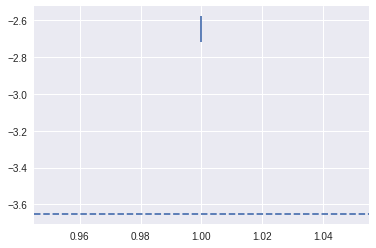

800        Accept rate: 0.775
1600       Accept rate: 0.804
2400       Accept rate: 0.777
3200       Accept rate: 0.769
4000       Accept rate: 0.771
Binning Statistics: Energy = -2.6031 +- 0.0553, Auto correlation Time = 0.4294
Step 1, dE/|E| = 0.2870, elapse = 1.0329


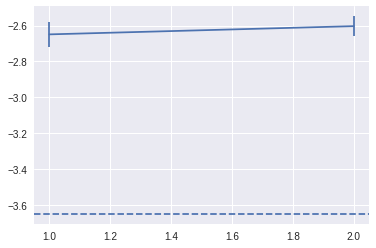

800        Accept rate: 0.731
1600       Accept rate: 0.774
2400       Accept rate: 0.760
3200       Accept rate: 0.772
4000       Accept rate: 0.780
Binning Statistics: Energy = -2.6574 +- 0.0511, Auto correlation Time = 0.3688
Step 2, dE/|E| = 0.2722, elapse = 1.1122


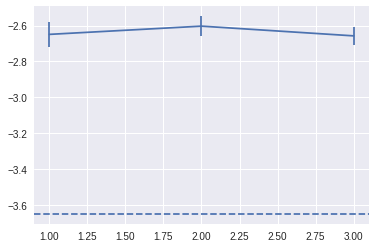

800        Accept rate: 0.728
1600       Accept rate: 0.745
2400       Accept rate: 0.746
3200       Accept rate: 0.740
4000       Accept rate: 0.762
Binning Statistics: Energy = -2.7036 +- 0.0571, Auto correlation Time = 0.4856
Step 3, dE/|E| = 0.2595, elapse = 1.1049


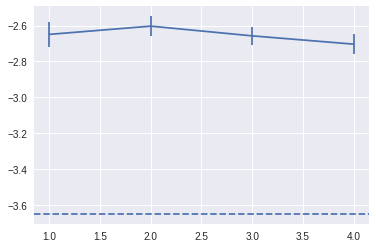

800        Accept rate: 0.696
1600       Accept rate: 0.751
2400       Accept rate: 0.699
3200       Accept rate: 0.709
4000       Accept rate: 0.709
Binning Statistics: Energy = -2.7151 +- 0.0438, Auto correlation Time = 0.3134
Step 4, dE/|E| = 0.2563, elapse = 1.1840


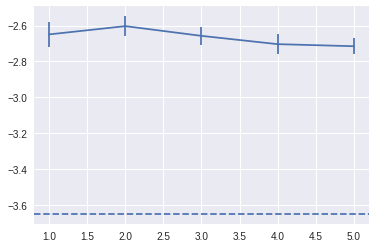

800        Accept rate: 0.677
1600       Accept rate: 0.686
2400       Accept rate: 0.690
3200       Accept rate: 0.703
4000       Accept rate: 0.656
Binning Statistics: Energy = -2.7533 +- 0.0503, Auto correlation Time = 0.4166
Step 5, dE/|E| = 0.2459, elapse = 1.1252


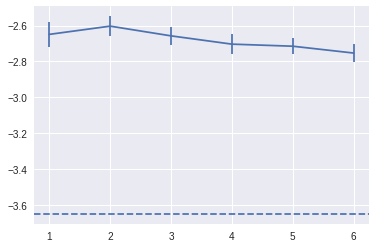

800        Accept rate: 0.698
1600       Accept rate: 0.735
2400       Accept rate: 0.713
3200       Accept rate: 0.676
4000       Accept rate: 0.699
Binning Statistics: Energy = -2.8116 +- 0.0558, Auto correlation Time = 0.5708
Step 6, dE/|E| = 0.2299, elapse = 1.1498


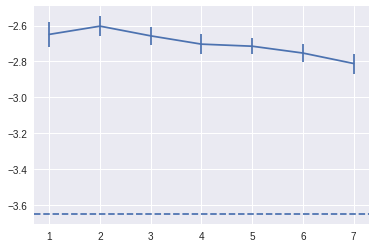

800        Accept rate: 0.609
1600       Accept rate: 0.670
2400       Accept rate: 0.636
3200       Accept rate: 0.660
4000       Accept rate: 0.641
Binning Statistics: Energy = -2.9206 +- 0.0488, Auto correlation Time = 0.5172
Step 7, dE/|E| = 0.2001, elapse = 1.1522


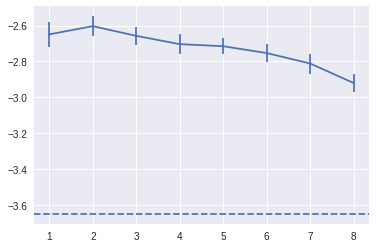

800        Accept rate: 0.645
1600       Accept rate: 0.674
2400       Accept rate: 0.601
3200       Accept rate: 0.632
4000       Accept rate: 0.621
Binning Statistics: Energy = -2.8966 +- 0.0477, Auto correlation Time = 0.5088
Step 8, dE/|E| = 0.2067, elapse = 1.1142


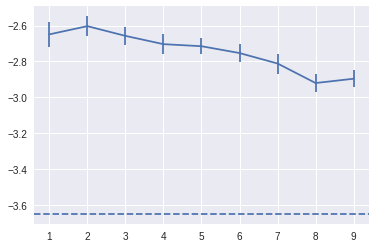

800        Accept rate: 0.603
1600       Accept rate: 0.636
2400       Accept rate: 0.600
3200       Accept rate: 0.623
4000       Accept rate: 0.611
Binning Statistics: Energy = -2.9717 +- 0.0424, Auto correlation Time = 0.4280
Step 9, dE/|E| = 0.1861, elapse = 1.1164


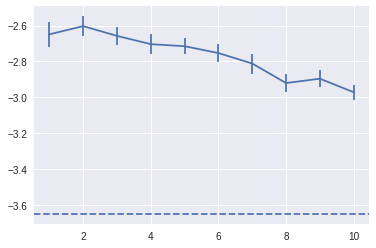

800        Accept rate: 0.569
1600       Accept rate: 0.540
2400       Accept rate: 0.594
3200       Accept rate: 0.581
4000       Accept rate: 0.598
Binning Statistics: Energy = -3.0267 +- 0.0438, Auto correlation Time = 0.4879
Step 10, dE/|E| = 0.1710, elapse = 1.1096


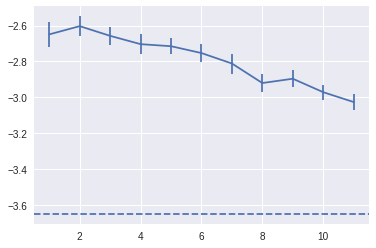

800        Accept rate: 0.568
1600       Accept rate: 0.540
2400       Accept rate: 0.565
3200       Accept rate: 0.562
4000       Accept rate: 0.578
Binning Statistics: Energy = -2.9158 +- 0.0432, Auto correlation Time = 0.4442
Step 11, dE/|E| = 0.2014, elapse = 1.0930


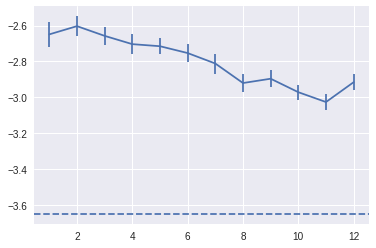

800        Accept rate: 0.475
1600       Accept rate: 0.484
2400       Accept rate: 0.580
3200       Accept rate: 0.598
4000       Accept rate: 0.540
Binning Statistics: Energy = -2.9500 +- 0.0453, Auto correlation Time = 0.4839
Step 12, dE/|E| = 0.1920, elapse = 1.1185


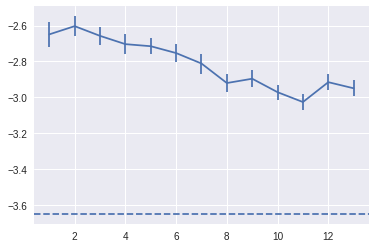

800        Accept rate: 0.556
1600       Accept rate: 0.537
2400       Accept rate: 0.551
3200       Accept rate: 0.556
4000       Accept rate: 0.537
Binning Statistics: Energy = -3.0229 +- 0.0416, Auto correlation Time = 0.4738
Step 13, dE/|E| = 0.1720, elapse = 1.1477


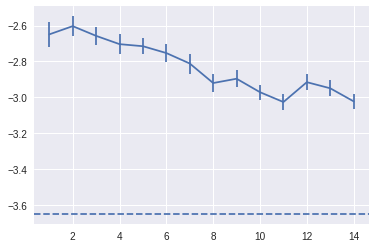

800        Accept rate: 0.494
1600       Accept rate: 0.542
2400       Accept rate: 0.529
3200       Accept rate: 0.500
4000       Accept rate: 0.529
Binning Statistics: Energy = -3.0760 +- 0.0415, Auto correlation Time = 0.5300
Step 14, dE/|E| = 0.1575, elapse = 1.1136


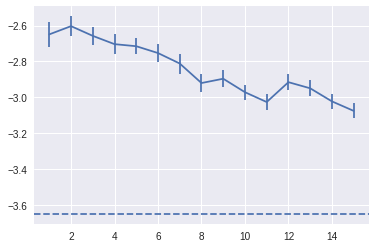

800        Accept rate: 0.505
1600       Accept rate: 0.495
2400       Accept rate: 0.539
3200       Accept rate: 0.468
4000       Accept rate: 0.501
Binning Statistics: Energy = -3.1763 +- 0.0482, Auto correlation Time = 0.7311
Step 15, dE/|E| = 0.1300, elapse = 1.1258


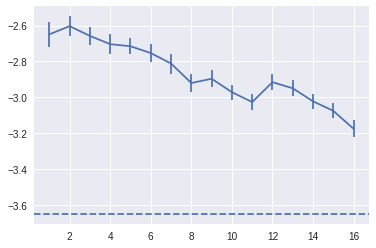

800        Accept rate: 0.527
1600       Accept rate: 0.504
2400       Accept rate: 0.537
3200       Accept rate: 0.463
4000       Accept rate: 0.464
Binning Statistics: Energy = -3.0874 +- 0.0481, Auto correlation Time = 0.6121
Step 16, dE/|E| = 0.1544, elapse = 1.1381


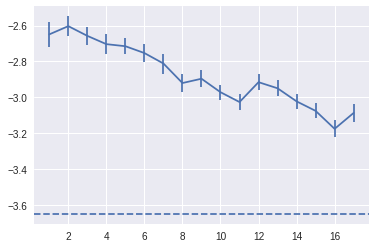

800        Accept rate: 0.445
1600       Accept rate: 0.510
2400       Accept rate: 0.529
3200       Accept rate: 0.495
4000       Accept rate: 0.450
Binning Statistics: Energy = -3.1727 +- 0.0385, Auto correlation Time = 0.4685
Step 17, dE/|E| = 0.1310, elapse = 1.2187


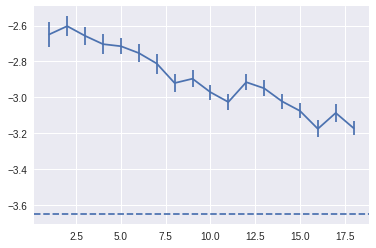

800        Accept rate: 0.492
1600       Accept rate: 0.469
2400       Accept rate: 0.490
3200       Accept rate: 0.486
4000       Accept rate: 0.495
Binning Statistics: Energy = -3.1721 +- 0.0398, Auto correlation Time = 0.4724
Step 18, dE/|E| = 0.1312, elapse = 1.1132


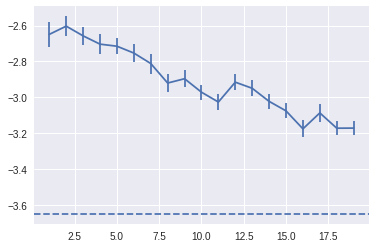

800        Accept rate: 0.458
1600       Accept rate: 0.444
2400       Accept rate: 0.482
3200       Accept rate: 0.495
4000       Accept rate: 0.461
Binning Statistics: Energy = -3.1857 +- 0.0343, Auto correlation Time = 0.3082
Step 19, dE/|E| = 0.1275, elapse = 1.1140


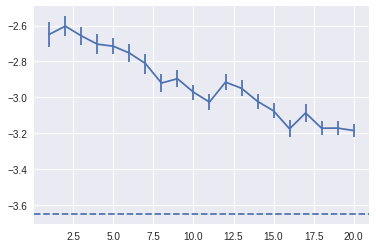

800        Accept rate: 0.450
1600       Accept rate: 0.434
2400       Accept rate: 0.458
3200       Accept rate: 0.482
4000       Accept rate: 0.526
Binning Statistics: Energy = -3.2067 +- 0.0389, Auto correlation Time = 0.4052
Step 20, dE/|E| = 0.1217, elapse = 1.0947


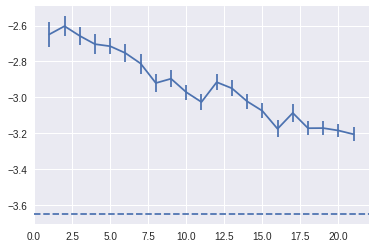

800        Accept rate: 0.475
1600       Accept rate: 0.495
2400       Accept rate: 0.445
3200       Accept rate: 0.466
4000       Accept rate: 0.429
Binning Statistics: Energy = -3.1995 +- 0.0441, Auto correlation Time = 0.6349
Step 21, dE/|E| = 0.1237, elapse = 1.1221


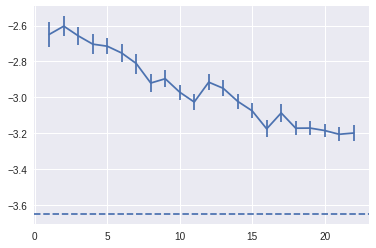

800        Accept rate: 0.463
1600       Accept rate: 0.425
2400       Accept rate: 0.481
3200       Accept rate: 0.490
4000       Accept rate: 0.463
Binning Statistics: Energy = -3.2546 +- 0.0375, Auto correlation Time = 0.4652
Step 22, dE/|E| = 0.1086, elapse = 1.0784


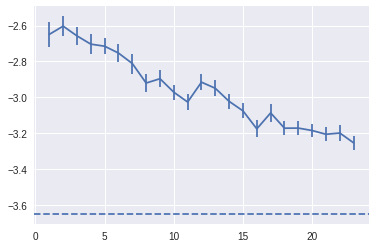

800        Accept rate: 0.492
1600       Accept rate: 0.434
2400       Accept rate: 0.516
3200       Accept rate: 0.496
4000       Accept rate: 0.443
Binning Statistics: Energy = -3.2420 +- 0.0322, Auto correlation Time = 0.3574
Step 23, dE/|E| = 0.1120, elapse = 1.1032


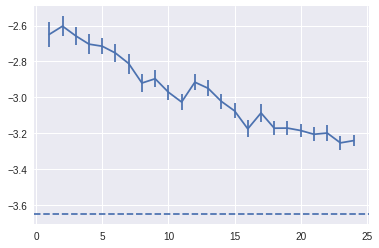

800        Accept rate: 0.476
1600       Accept rate: 0.412
2400       Accept rate: 0.435
3200       Accept rate: 0.427
4000       Accept rate: 0.439
Binning Statistics: Energy = -3.2209 +- 0.0343, Auto correlation Time = 0.4192
Step 24, dE/|E| = 0.1178, elapse = 1.1374


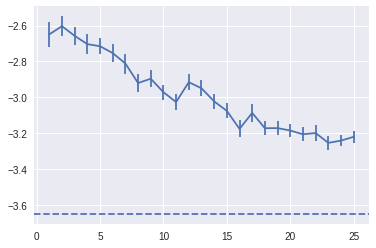

800        Accept rate: 0.441
1600       Accept rate: 0.466
2400       Accept rate: 0.443
3200       Accept rate: 0.476
4000       Accept rate: 0.420
Binning Statistics: Energy = -3.2586 +- 0.0332, Auto correlation Time = 0.4437
Step 25, dE/|E| = 0.1075, elapse = 1.1296


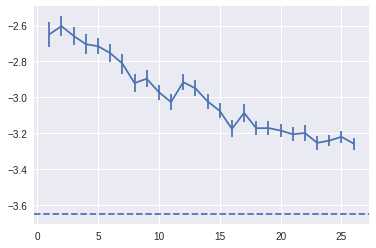

800        Accept rate: 0.439
1600       Accept rate: 0.479
2400       Accept rate: 0.434
3200       Accept rate: 0.453
4000       Accept rate: 0.451
Binning Statistics: Energy = -3.2404 +- 0.0316, Auto correlation Time = 0.4860
Step 26, dE/|E| = 0.1125, elapse = 1.1142


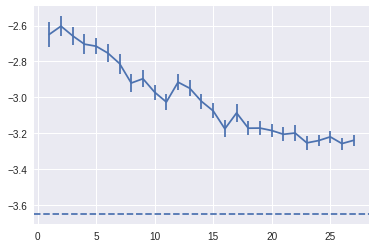

800        Accept rate: 0.517
1600       Accept rate: 0.494
2400       Accept rate: 0.471
3200       Accept rate: 0.432
4000       Accept rate: 0.434
Binning Statistics: Energy = -3.3363 +- 0.0281, Auto correlation Time = 0.3773
Step 27, dE/|E| = 0.0862, elapse = 1.1385


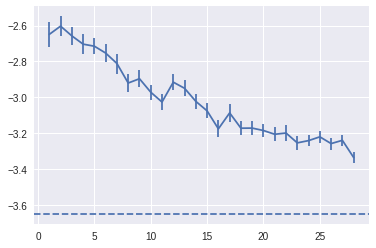

800        Accept rate: 0.465
1600       Accept rate: 0.453
2400       Accept rate: 0.474
3200       Accept rate: 0.494
4000       Accept rate: 0.394
Binning Statistics: Energy = -3.3068 +- 0.0324, Auto correlation Time = 0.5113
Step 28, dE/|E| = 0.0943, elapse = 1.0920


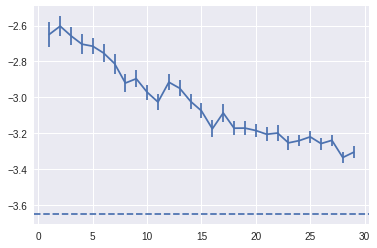

800        Accept rate: 0.429
1600       Accept rate: 0.505
2400       Accept rate: 0.426
3200       Accept rate: 0.415
4000       Accept rate: 0.436
Binning Statistics: Energy = -3.2718 +- 0.0299, Auto correlation Time = 0.5044
Step 29, dE/|E| = 0.1039, elapse = 1.1162


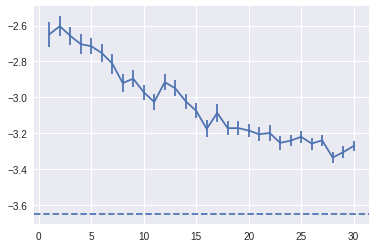

800        Accept rate: 0.431
1600       Accept rate: 0.476
2400       Accept rate: 0.494
3200       Accept rate: 0.460
4000       Accept rate: 0.451
Binning Statistics: Energy = -3.2893 +- 0.0298, Auto correlation Time = 0.5173
Step 30, dE/|E| = 0.0991, elapse = 1.1992


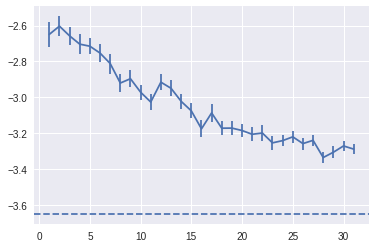

800        Accept rate: 0.430
1600       Accept rate: 0.480
2400       Accept rate: 0.481
3200       Accept rate: 0.507
4000       Accept rate: 0.417
Binning Statistics: Energy = -3.3089 +- 0.0204, Auto correlation Time = 0.2690
Step 31, dE/|E| = 0.0937, elapse = 1.1351


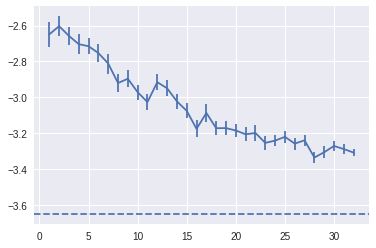

800        Accept rate: 0.451
1600       Accept rate: 0.499
2400       Accept rate: 0.386
3200       Accept rate: 0.421
4000       Accept rate: 0.504
Binning Statistics: Energy = -3.2896 +- 0.0255, Auto correlation Time = 0.5095
Step 32, dE/|E| = 0.0990, elapse = 1.1323


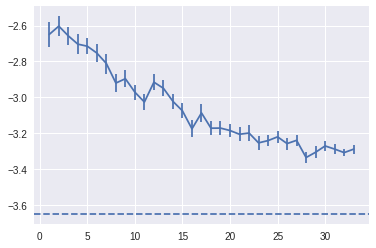

800        Accept rate: 0.424
1600       Accept rate: 0.481
2400       Accept rate: 0.453
3200       Accept rate: 0.484
4000       Accept rate: 0.400
Binning Statistics: Energy = -3.3585 +- 0.0262, Auto correlation Time = 0.5719
Step 33, dE/|E| = 0.0801, elapse = 1.1319


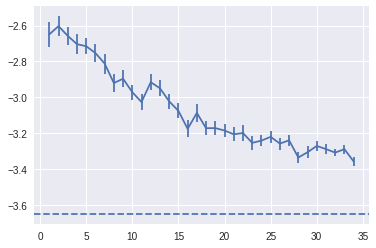

800        Accept rate: 0.454
1600       Accept rate: 0.439
2400       Accept rate: 0.429
3200       Accept rate: 0.412
4000       Accept rate: 0.456
Binning Statistics: Energy = -3.3194 +- 0.0251, Auto correlation Time = 0.5677
Step 34, dE/|E| = 0.0909, elapse = 1.1224


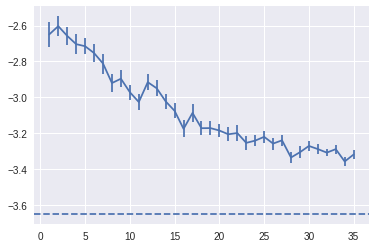

800        Accept rate: 0.466
1600       Accept rate: 0.465
2400       Accept rate: 0.393
3200       Accept rate: 0.441
4000       Accept rate: 0.451
Binning Statistics: Energy = -3.3800 +- 0.0205, Auto correlation Time = 0.3683
Step 35, dE/|E| = 0.0743, elapse = 1.1241


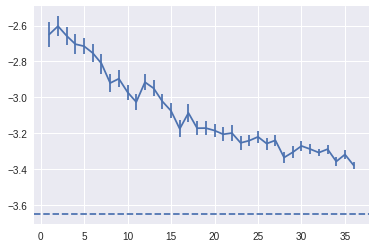

800        Accept rate: 0.415
1600       Accept rate: 0.429
2400       Accept rate: 0.424
3200       Accept rate: 0.449
4000       Accept rate: 0.403
Binning Statistics: Energy = -3.3629 +- 0.0248, Auto correlation Time = 0.6185
Step 36, dE/|E| = 0.0789, elapse = 1.1242


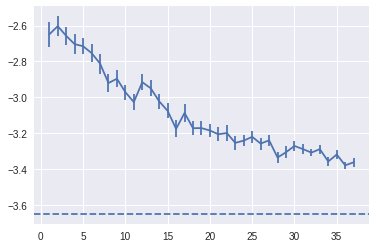

800        Accept rate: 0.448
1600       Accept rate: 0.436
2400       Accept rate: 0.460
3200       Accept rate: 0.484
4000       Accept rate: 0.445
Binning Statistics: Energy = -3.3470 +- 0.0224, Auto correlation Time = 0.5118
Step 37, dE/|E| = 0.0833, elapse = 1.1422


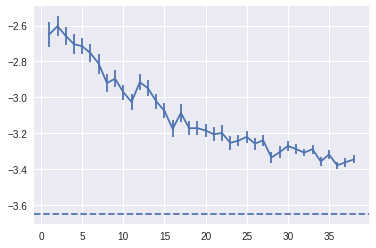

800        Accept rate: 0.455
1600       Accept rate: 0.435
2400       Accept rate: 0.371
3200       Accept rate: 0.417
4000       Accept rate: 0.403
Binning Statistics: Energy = -3.3557 +- 0.0221, Auto correlation Time = 0.5722
Step 38, dE/|E| = 0.0809, elapse = 1.1236


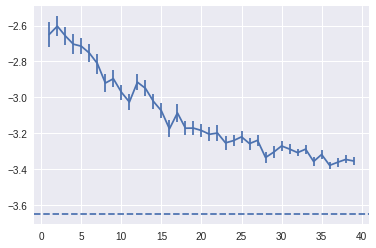

800        Accept rate: 0.448
1600       Accept rate: 0.398
2400       Accept rate: 0.434
3200       Accept rate: 0.429
4000       Accept rate: 0.407
Binning Statistics: Energy = -3.4046 +- 0.0202, Auto correlation Time = 0.5271
Step 39, dE/|E| = 0.0675, elapse = 1.1261


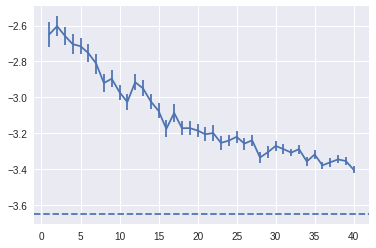

800        Accept rate: 0.451
1600       Accept rate: 0.425
2400       Accept rate: 0.430
3200       Accept rate: 0.439
4000       Accept rate: 0.440
Binning Statistics: Energy = -3.3750 +- 0.0176, Auto correlation Time = 0.4663
Step 40, dE/|E| = 0.0756, elapse = 1.1306


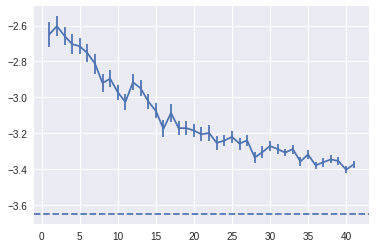

800        Accept rate: 0.459
1600       Accept rate: 0.405
2400       Accept rate: 0.445
3200       Accept rate: 0.436
4000       Accept rate: 0.445
Binning Statistics: Energy = -3.4140 +- 0.0180, Auto correlation Time = 0.4956
Step 41, dE/|E| = 0.0649, elapse = 1.1574


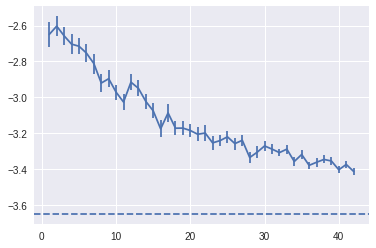

800        Accept rate: 0.386
1600       Accept rate: 0.470
2400       Accept rate: 0.463
3200       Accept rate: 0.417
4000       Accept rate: 0.403
Binning Statistics: Energy = -3.3931 +- 0.0180, Auto correlation Time = 0.5189
Step 42, dE/|E| = 0.0707, elapse = 1.1974


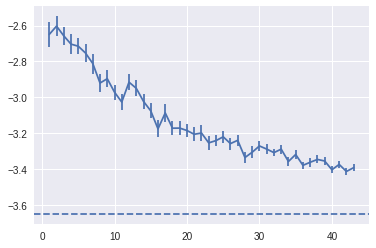

800        Accept rate: 0.466
1600       Accept rate: 0.386
2400       Accept rate: 0.399
3200       Accept rate: 0.454
4000       Accept rate: 0.369
Binning Statistics: Energy = -3.4188 +- 0.0175, Auto correlation Time = 0.6087
Step 43, dE/|E| = 0.0636, elapse = 1.1226


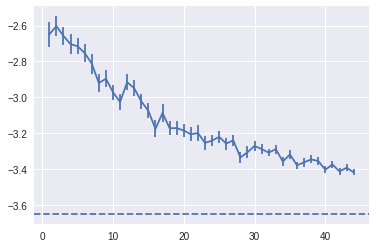

800        Accept rate: 0.424
1600       Accept rate: 0.360
2400       Accept rate: 0.422
3200       Accept rate: 0.414
4000       Accept rate: 0.369
Binning Statistics: Energy = -3.4454 +- 0.0183, Auto correlation Time = 0.5933
Step 44, dE/|E| = 0.0563, elapse = 1.1469


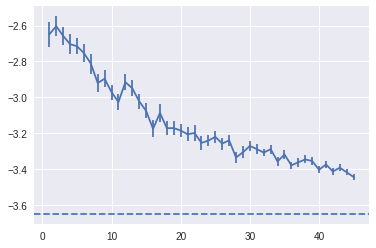

800        Accept rate: 0.411
1600       Accept rate: 0.419
2400       Accept rate: 0.371
3200       Accept rate: 0.420
4000       Accept rate: 0.401
Binning Statistics: Energy = -3.4513 +- 0.0155, Auto correlation Time = 0.4684
Step 45, dE/|E| = 0.0547, elapse = 1.1296


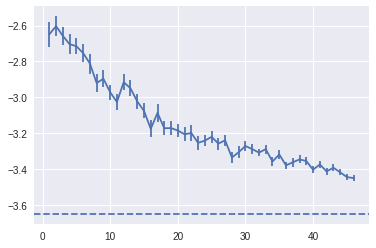

800        Accept rate: 0.448
1600       Accept rate: 0.393
2400       Accept rate: 0.393
3200       Accept rate: 0.375
4000       Accept rate: 0.424
Binning Statistics: Energy = -3.4600 +- 0.0108, Auto correlation Time = 0.2832
Step 46, dE/|E| = 0.0523, elapse = 1.1383


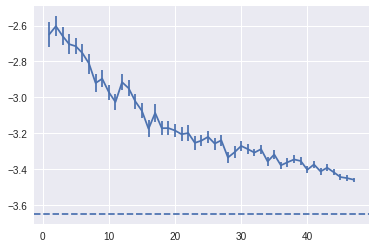

800        Accept rate: 0.431
1600       Accept rate: 0.456
2400       Accept rate: 0.403
3200       Accept rate: 0.415
4000       Accept rate: 0.399
Binning Statistics: Energy = -3.4540 +- 0.0136, Auto correlation Time = 0.4964
Step 47, dE/|E| = 0.0540, elapse = 1.1176


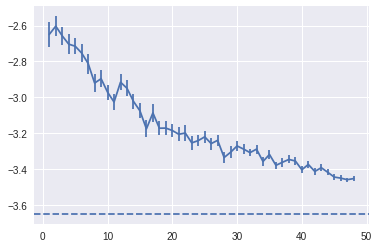

800        Accept rate: 0.385
1600       Accept rate: 0.380
2400       Accept rate: 0.405
3200       Accept rate: 0.436
4000       Accept rate: 0.419
Binning Statistics: Energy = -3.4848 +- 0.0154, Auto correlation Time = 0.5344
Step 48, dE/|E| = 0.0456, elapse = 1.1305


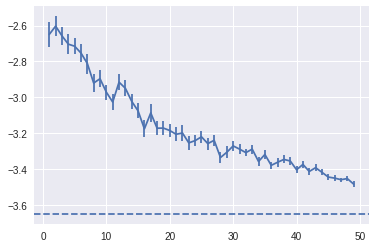

800        Accept rate: 0.440
1600       Accept rate: 0.424
2400       Accept rate: 0.383
3200       Accept rate: 0.406
4000       Accept rate: 0.334
Binning Statistics: Energy = -3.4825 +- 0.0129, Auto correlation Time = 0.4459
Step 49, dE/|E| = 0.0462, elapse = 1.1430


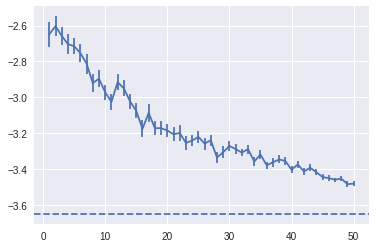

800        Accept rate: 0.394
1600       Accept rate: 0.394
2400       Accept rate: 0.352
3200       Accept rate: 0.369
4000       Accept rate: 0.427
Binning Statistics: Energy = -3.5056 +- 0.0146, Auto correlation Time = 0.5747
Step 50, dE/|E| = 0.0399, elapse = 1.1265


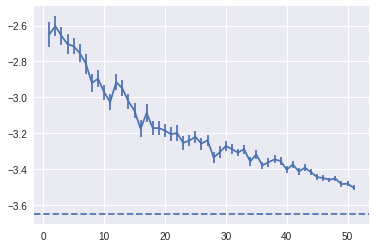

800        Accept rate: 0.396
1600       Accept rate: 0.422
2400       Accept rate: 0.422
3200       Accept rate: 0.445
4000       Accept rate: 0.431
Binning Statistics: Energy = -3.5212 +- 0.0149, Auto correlation Time = 0.6090
Step 51, dE/|E| = 0.0356, elapse = 1.1277


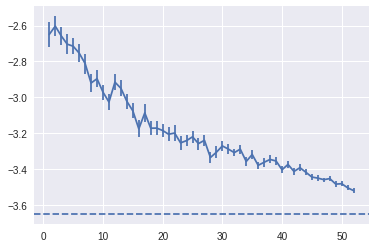

800        Accept rate: 0.411
1600       Accept rate: 0.391
2400       Accept rate: 0.432
3200       Accept rate: 0.351
4000       Accept rate: 0.366
Binning Statistics: Energy = -3.5107 +- 0.0142, Auto correlation Time = 0.6119
Step 52, dE/|E| = 0.0385, elapse = 1.1128


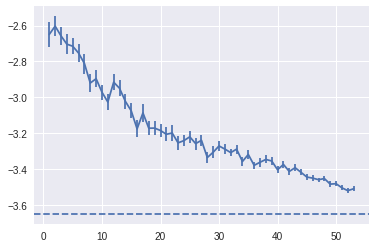

800        Accept rate: 0.357
1600       Accept rate: 0.430
2400       Accept rate: 0.389
3200       Accept rate: 0.409
4000       Accept rate: 0.383
Binning Statistics: Energy = -3.5047 +- 0.0129, Auto correlation Time = 0.5082
Step 53, dE/|E| = 0.0401, elapse = 1.1038


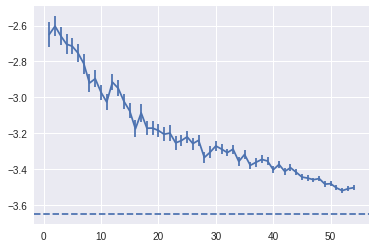

800        Accept rate: 0.333
1600       Accept rate: 0.434
2400       Accept rate: 0.396
3200       Accept rate: 0.388
4000       Accept rate: 0.443
Binning Statistics: Energy = -3.5155 +- 0.0133, Auto correlation Time = 0.5846
Step 54, dE/|E| = 0.0371, elapse = 1.1048


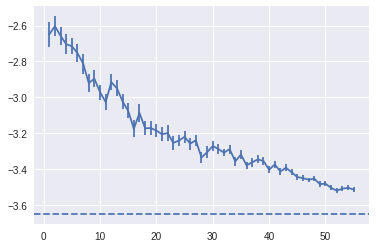

800        Accept rate: 0.431
1600       Accept rate: 0.379
2400       Accept rate: 0.381
3200       Accept rate: 0.389
4000       Accept rate: 0.417
Binning Statistics: Energy = -3.5351 +- 0.0109, Auto correlation Time = 0.4015
Step 55, dE/|E| = 0.0318, elapse = 1.1649


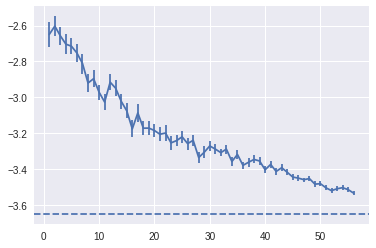

800        Accept rate: 0.364
1600       Accept rate: 0.388
2400       Accept rate: 0.426
3200       Accept rate: 0.365
4000       Accept rate: 0.440
Binning Statistics: Energy = -3.5387 +- 0.0102, Auto correlation Time = 0.4003
Step 56, dE/|E| = 0.0308, elapse = 1.1062


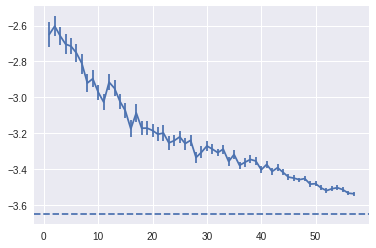

800        Accept rate: 0.379
1600       Accept rate: 0.469
2400       Accept rate: 0.379
3200       Accept rate: 0.450
4000       Accept rate: 0.434
Binning Statistics: Energy = -3.5319 +- 0.0108, Auto correlation Time = 0.4353
Step 57, dE/|E| = 0.0327, elapse = 1.1126


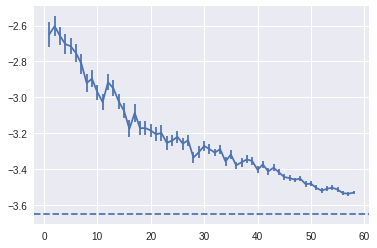

800        Accept rate: 0.422
1600       Accept rate: 0.401
2400       Accept rate: 0.450
3200       Accept rate: 0.450
4000       Accept rate: 0.359
Binning Statistics: Energy = -3.5261 +- 0.0124, Auto correlation Time = 0.6483
Step 58, dE/|E| = 0.0342, elapse = 1.1097


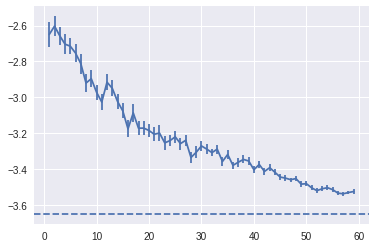

800        Accept rate: 0.420
1600       Accept rate: 0.417
2400       Accept rate: 0.432
3200       Accept rate: 0.381
4000       Accept rate: 0.369
Binning Statistics: Energy = -3.5169 +- 0.0083, Auto correlation Time = 0.2871
Step 59, dE/|E| = 0.0367, elapse = 1.1050


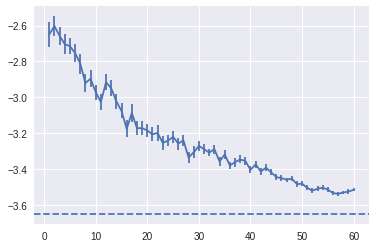

800        Accept rate: 0.376
1600       Accept rate: 0.336
2400       Accept rate: 0.395
3200       Accept rate: 0.419
4000       Accept rate: 0.374
Binning Statistics: Energy = -3.5306 +- 0.0112, Auto correlation Time = 0.5509
Step 60, dE/|E| = 0.0330, elapse = 1.1082


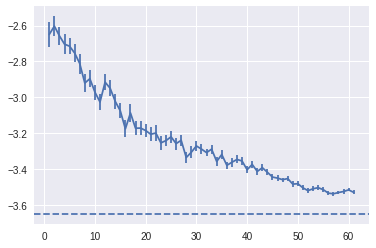

800        Accept rate: 0.436
1600       Accept rate: 0.465
2400       Accept rate: 0.383
3200       Accept rate: 0.438
4000       Accept rate: 0.391
Binning Statistics: Energy = -3.5527 +- 0.0106, Auto correlation Time = 0.4255
Step 61, dE/|E| = 0.0270, elapse = 1.1198


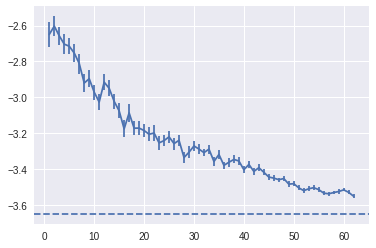

800        Accept rate: 0.410
1600       Accept rate: 0.407
2400       Accept rate: 0.404
3200       Accept rate: 0.425
4000       Accept rate: 0.349
Binning Statistics: Energy = -3.5749 +- 0.0127, Auto correlation Time = 0.6247
Step 62, dE/|E| = 0.0209, elapse = 1.0990


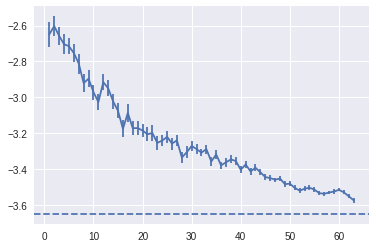

800        Accept rate: 0.384
1600       Accept rate: 0.354
2400       Accept rate: 0.406
3200       Accept rate: 0.379
4000       Accept rate: 0.456
Binning Statistics: Energy = -3.5661 +- 0.0096, Auto correlation Time = 0.3887
Step 63, dE/|E| = 0.0233, elapse = 1.1133


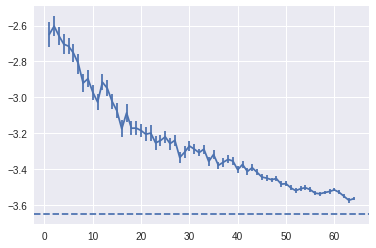

800        Accept rate: 0.404
1600       Accept rate: 0.396
2400       Accept rate: 0.406
3200       Accept rate: 0.384
4000       Accept rate: 0.345
Binning Statistics: Energy = -3.5473 +- 0.0118, Auto correlation Time = 0.5545
Step 64, dE/|E| = 0.0284, elapse = 1.1272


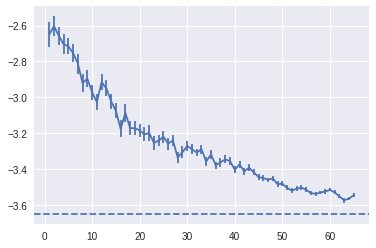

800        Accept rate: 0.426
1600       Accept rate: 0.398
2400       Accept rate: 0.443
3200       Accept rate: 0.395
4000       Accept rate: 0.405
Binning Statistics: Energy = -3.5632 +- 0.0109, Auto correlation Time = 0.5568
Step 65, dE/|E| = 0.0241, elapse = 1.1345


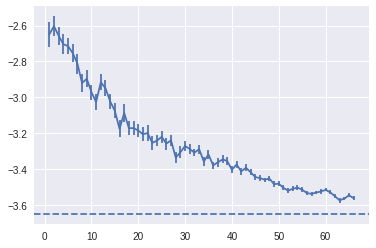

800        Accept rate: 0.436
1600       Accept rate: 0.396
2400       Accept rate: 0.426
3200       Accept rate: 0.424
4000       Accept rate: 0.366
Binning Statistics: Energy = -3.5623 +- 0.0093, Auto correlation Time = 0.4256
Step 66, dE/|E| = 0.0243, elapse = 1.1256


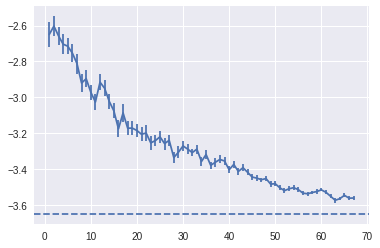

800        Accept rate: 0.390
1600       Accept rate: 0.422
2400       Accept rate: 0.403
3200       Accept rate: 0.460
4000       Accept rate: 0.362
Binning Statistics: Energy = -3.5648 +- 0.0102, Auto correlation Time = 0.5482
Step 67, dE/|E| = 0.0236, elapse = 1.1810


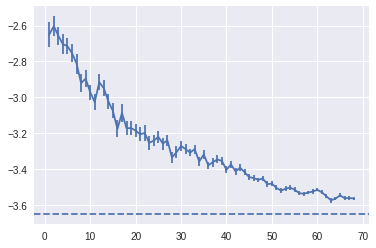

800        Accept rate: 0.432
1600       Accept rate: 0.375
2400       Accept rate: 0.441
3200       Accept rate: 0.425
4000       Accept rate: 0.380
Binning Statistics: Energy = -3.5599 +- 0.0093, Auto correlation Time = 0.4170
Step 68, dE/|E| = 0.0250, elapse = 1.1166


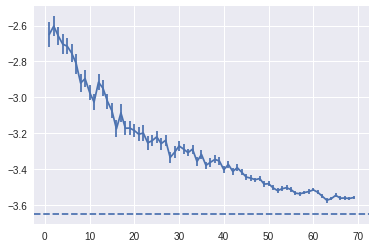

800        Accept rate: 0.352
1600       Accept rate: 0.355
2400       Accept rate: 0.416
3200       Accept rate: 0.355
4000       Accept rate: 0.445
Binning Statistics: Energy = -3.5409 +- 0.0088, Auto correlation Time = 0.3860
Step 69, dE/|E| = 0.0302, elapse = 1.1437


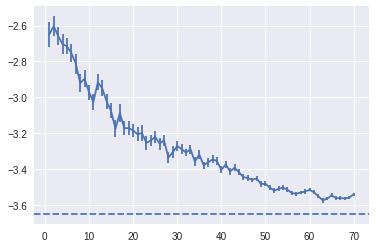

800        Accept rate: 0.380
1600       Accept rate: 0.396
2400       Accept rate: 0.386
3200       Accept rate: 0.389
4000       Accept rate: 0.345
Binning Statistics: Energy = -3.5600 +- 0.0095, Auto correlation Time = 0.4554
Step 70, dE/|E| = 0.0250, elapse = 1.0939


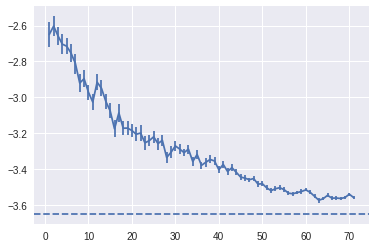

800        Accept rate: 0.376
1600       Accept rate: 0.426
2400       Accept rate: 0.425
3200       Accept rate: 0.417
4000       Accept rate: 0.405
Binning Statistics: Energy = -3.5860 +- 0.0087, Auto correlation Time = 0.3921
Step 71, dE/|E| = 0.0178, elapse = 1.1047


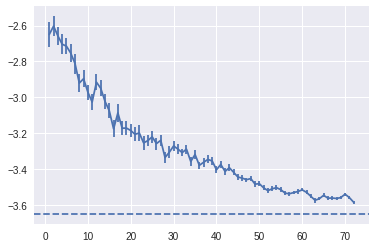

800        Accept rate: 0.421
1600       Accept rate: 0.324
2400       Accept rate: 0.403
3200       Accept rate: 0.366
4000       Accept rate: 0.411
Binning Statistics: Energy = -3.5634 +- 0.0126, Auto correlation Time = 0.7477
Step 72, dE/|E| = 0.0240, elapse = 1.1193


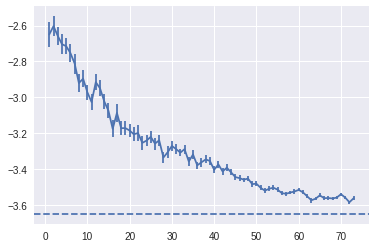

800        Accept rate: 0.429
1600       Accept rate: 0.429
2400       Accept rate: 0.440
3200       Accept rate: 0.334
4000       Accept rate: 0.355
Binning Statistics: Energy = -3.5748 +- 0.0107, Auto correlation Time = 0.5377
Step 73, dE/|E| = 0.0209, elapse = 1.1132


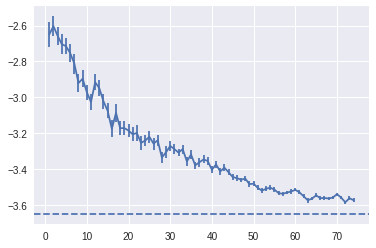

800        Accept rate: 0.384
1600       Accept rate: 0.401
2400       Accept rate: 0.434
3200       Accept rate: 0.390
4000       Accept rate: 0.398
Binning Statistics: Energy = -3.5750 +- 0.0091, Auto correlation Time = 0.3603
Step 74, dE/|E| = 0.0208, elapse = 1.1229


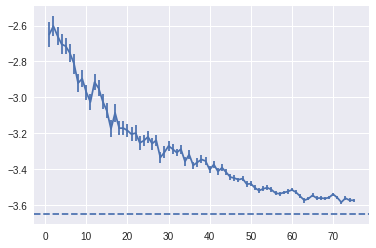

800        Accept rate: 0.421
1600       Accept rate: 0.400
2400       Accept rate: 0.454
3200       Accept rate: 0.388
4000       Accept rate: 0.398
Binning Statistics: Energy = -3.5882 +- 0.0095, Auto correlation Time = 0.5400
Step 75, dE/|E| = 0.0172, elapse = 1.1369


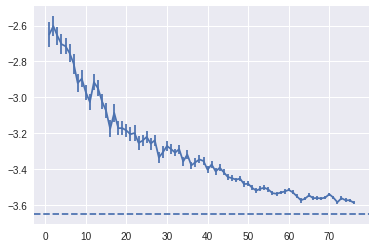

800        Accept rate: 0.386
1600       Accept rate: 0.384
2400       Accept rate: 0.385
3200       Accept rate: 0.443
4000       Accept rate: 0.453
Binning Statistics: Energy = -3.5749 +- 0.0110, Auto correlation Time = 0.6506
Step 76, dE/|E| = 0.0209, elapse = 1.1238


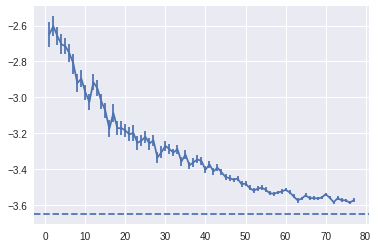

800        Accept rate: 0.401
1600       Accept rate: 0.405
2400       Accept rate: 0.414
3200       Accept rate: 0.414
4000       Accept rate: 0.420
Binning Statistics: Energy = -3.5606 +- 0.0091, Auto correlation Time = 0.4086
Step 77, dE/|E| = 0.0248, elapse = 1.1331


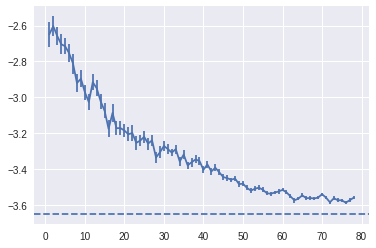

800        Accept rate: 0.395
1600       Accept rate: 0.384
2400       Accept rate: 0.401
3200       Accept rate: 0.312
4000       Accept rate: 0.386
Binning Statistics: Energy = -3.5716 +- 0.0107, Auto correlation Time = 0.5822
Step 78, dE/|E| = 0.0218, elapse = 1.1354


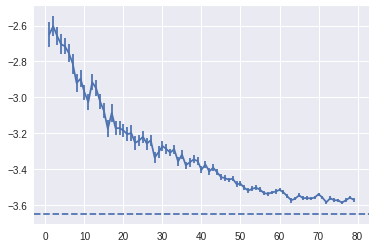

800        Accept rate: 0.350
1600       Accept rate: 0.405
2400       Accept rate: 0.406
3200       Accept rate: 0.390
4000       Accept rate: 0.404
Binning Statistics: Energy = -3.5781 +- 0.0098, Auto correlation Time = 0.4178
Step 79, dE/|E| = 0.0200, elapse = 1.1833


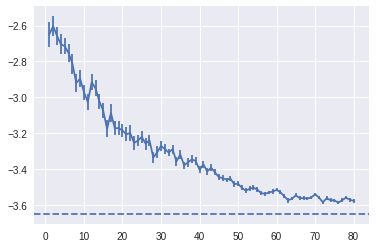

800        Accept rate: 0.435
1600       Accept rate: 0.427
2400       Accept rate: 0.370
3200       Accept rate: 0.339
4000       Accept rate: 0.393
Binning Statistics: Energy = -3.5826 +- 0.0114, Auto correlation Time = 0.6261
Step 80, dE/|E| = 0.0188, elapse = 1.1197


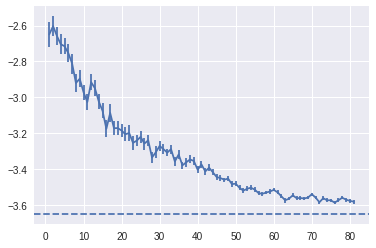

800        Accept rate: 0.440
1600       Accept rate: 0.414
2400       Accept rate: 0.405
3200       Accept rate: 0.443
4000       Accept rate: 0.453
Binning Statistics: Energy = -3.5827 +- 0.0092, Auto correlation Time = 0.4568
Step 81, dE/|E| = 0.0187, elapse = 1.1310


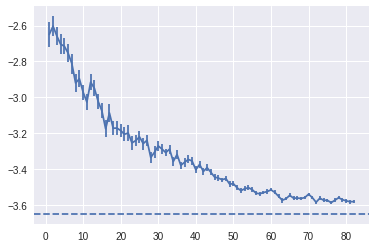

800        Accept rate: 0.406
1600       Accept rate: 0.414
2400       Accept rate: 0.388
3200       Accept rate: 0.354
4000       Accept rate: 0.419
Binning Statistics: Energy = -3.5826 +- 0.0083, Auto correlation Time = 0.4038
Step 82, dE/|E| = 0.0188, elapse = 1.1193


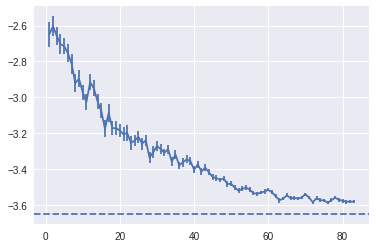

800        Accept rate: 0.404
1600       Accept rate: 0.400
2400       Accept rate: 0.420
3200       Accept rate: 0.431
4000       Accept rate: 0.396
Binning Statistics: Energy = -3.5807 +- 0.0089, Auto correlation Time = 0.3960
Step 83, dE/|E| = 0.0193, elapse = 1.1203


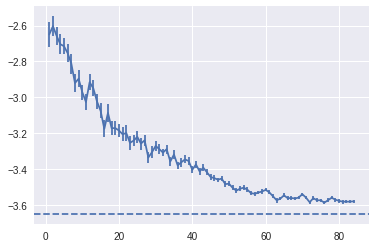

800        Accept rate: 0.420
1600       Accept rate: 0.451
2400       Accept rate: 0.419
3200       Accept rate: 0.343
4000       Accept rate: 0.429
Binning Statistics: Energy = -3.5865 +- 0.0109, Auto correlation Time = 0.6241
Step 84, dE/|E| = 0.0177, elapse = 1.1303


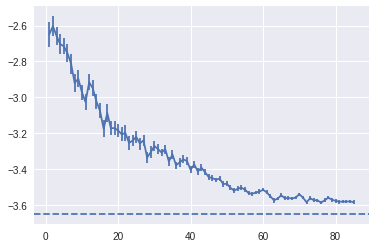

800        Accept rate: 0.384
1600       Accept rate: 0.357
2400       Accept rate: 0.391
3200       Accept rate: 0.421
4000       Accept rate: 0.404
Binning Statistics: Energy = -3.5641 +- 0.0089, Auto correlation Time = 0.4425
Step 85, dE/|E| = 0.0238, elapse = 1.1411


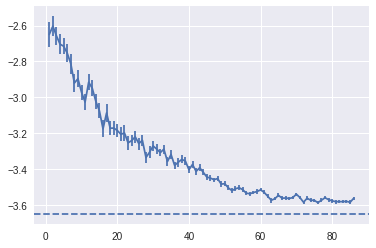

800        Accept rate: 0.371
1600       Accept rate: 0.414
2400       Accept rate: 0.359
3200       Accept rate: 0.449
4000       Accept rate: 0.417
Binning Statistics: Energy = -3.5842 +- 0.0105, Auto correlation Time = 0.5814
Step 86, dE/|E| = 0.0183, elapse = 1.1146


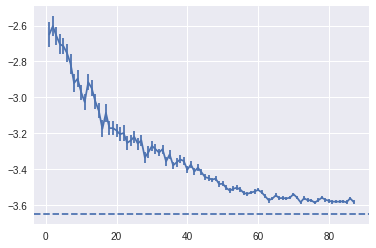

800        Accept rate: 0.398
1600       Accept rate: 0.427
2400       Accept rate: 0.407
3200       Accept rate: 0.376
4000       Accept rate: 0.409
Binning Statistics: Energy = -3.5804 +- 0.0084, Auto correlation Time = 0.4228
Step 87, dE/|E| = 0.0194, elapse = 1.1296


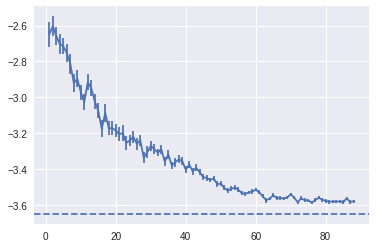

800        Accept rate: 0.356
1600       Accept rate: 0.429
2400       Accept rate: 0.401
3200       Accept rate: 0.393
4000       Accept rate: 0.383
Binning Statistics: Energy = -3.5951 +- 0.0112, Auto correlation Time = 0.6882
Step 88, dE/|E| = 0.0153, elapse = 1.1294


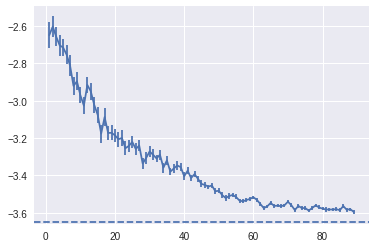

800        Accept rate: 0.398
1600       Accept rate: 0.399
2400       Accept rate: 0.394
3200       Accept rate: 0.374
4000       Accept rate: 0.390
Binning Statistics: Energy = -3.5947 +- 0.0095, Auto correlation Time = 0.5038
Step 89, dE/|E| = 0.0154, elapse = 1.1216


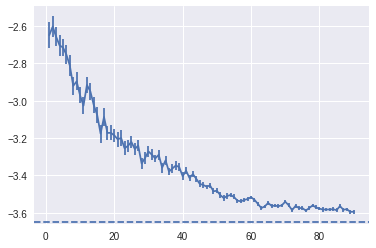

800        Accept rate: 0.421
1600       Accept rate: 0.374
2400       Accept rate: 0.469
3200       Accept rate: 0.344
4000       Accept rate: 0.422
Binning Statistics: Energy = -3.5867 +- 0.0099, Auto correlation Time = 0.5739
Step 90, dE/|E| = 0.0176, elapse = 1.1076


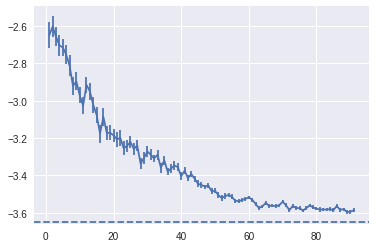

800        Accept rate: 0.450
1600       Accept rate: 0.391
2400       Accept rate: 0.411
3200       Accept rate: 0.379
4000       Accept rate: 0.380
Binning Statistics: Energy = -3.5765 +- 0.0103, Auto correlation Time = 0.6074
Step 91, dE/|E| = 0.0204, elapse = 1.1783


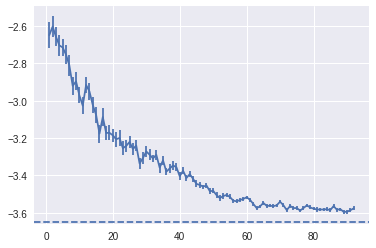

800        Accept rate: 0.419
1600       Accept rate: 0.359
2400       Accept rate: 0.365
3200       Accept rate: 0.412
4000       Accept rate: 0.329
Binning Statistics: Energy = -3.5819 +- 0.0097, Auto correlation Time = 0.5194
Step 92, dE/|E| = 0.0189, elapse = 1.1049


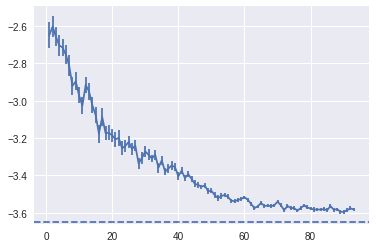

800        Accept rate: 0.396
1600       Accept rate: 0.385
2400       Accept rate: 0.376
3200       Accept rate: 0.453
4000       Accept rate: 0.399
Binning Statistics: Energy = -3.5842 +- 0.0084, Auto correlation Time = 0.4571
Step 93, dE/|E| = 0.0183, elapse = 1.1300


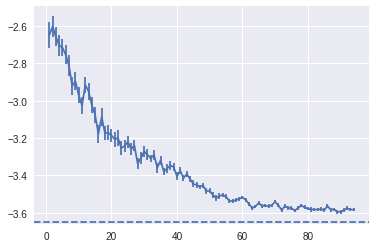

800        Accept rate: 0.441
1600       Accept rate: 0.403
2400       Accept rate: 0.405
3200       Accept rate: 0.375
4000       Accept rate: 0.381
Binning Statistics: Energy = -3.5977 +- 0.0092, Auto correlation Time = 0.5498
Step 94, dE/|E| = 0.0146, elapse = 1.1375


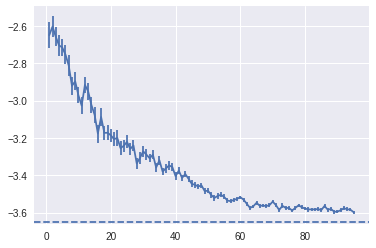

800        Accept rate: 0.355
1600       Accept rate: 0.357
2400       Accept rate: 0.410
3200       Accept rate: 0.407
4000       Accept rate: 0.412
Binning Statistics: Energy = -3.5877 +- 0.0074, Auto correlation Time = 0.3686
Step 95, dE/|E| = 0.0174, elapse = 1.1266


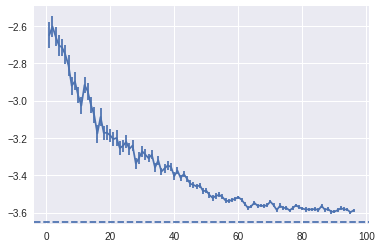

800        Accept rate: 0.432
1600       Accept rate: 0.388
2400       Accept rate: 0.396
3200       Accept rate: 0.438
4000       Accept rate: 0.416
Binning Statistics: Energy = -3.5857 +- 0.0081, Auto correlation Time = 0.3832
Step 96, dE/|E| = 0.0179, elapse = 1.1236


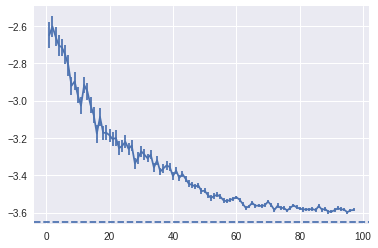

800        Accept rate: 0.399
1600       Accept rate: 0.359
2400       Accept rate: 0.364
3200       Accept rate: 0.476
4000       Accept rate: 0.417
Binning Statistics: Energy = -3.5933 +- 0.0092, Auto correlation Time = 0.5697
Step 97, dE/|E| = 0.0158, elapse = 1.1232


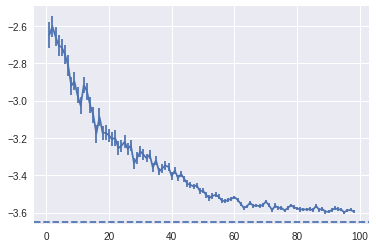

800        Accept rate: 0.346
1600       Accept rate: 0.417
2400       Accept rate: 0.445
3200       Accept rate: 0.367
4000       Accept rate: 0.388
Binning Statistics: Energy = -3.5894 +- 0.0087, Auto correlation Time = 0.5019
Step 98, dE/|E| = 0.0169, elapse = 1.0895


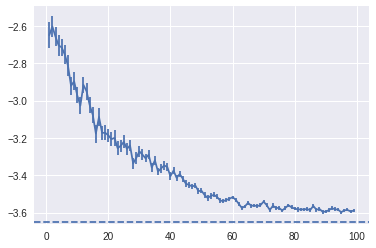

800        Accept rate: 0.374
1600       Accept rate: 0.424
2400       Accept rate: 0.344
3200       Accept rate: 0.422
4000       Accept rate: 0.427
Binning Statistics: Energy = -3.5907 +- 0.0077, Auto correlation Time = 0.4208
Step 99, dE/|E| = 0.0166, elapse = 1.1316


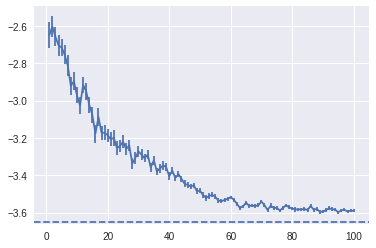

800        Accept rate: 0.450
1600       Accept rate: 0.371
2400       Accept rate: 0.372
3200       Accept rate: 0.404
4000       Accept rate: 0.388
Binning Statistics: Energy = -3.5696 +- 0.0080, Auto correlation Time = 0.4394
Step 100, dE/|E| = 0.0223, elapse = 1.1416


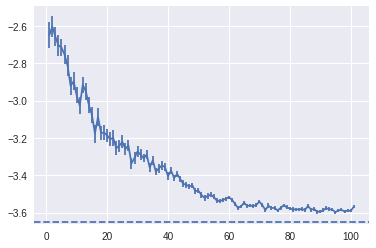

In [8]:
%matplotlib inline
import time
import matplotlib.pyplot as plt

# set random number seed
use_cuda = False
seed = 10086
torch.manual_seed(seed)
if use_cuda: torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
max_iter = 100
num_spin = 8
num_hidden = 16
E_exact = -3.65109341

# visualize the loss history
energy_list, precision_list = [], []
def _update_curve(energy, precision):
    energy_list.append(energy)
    precision_list.append(precision)
    plt.errorbar(np.arange(1, len(energy_list) + 1), energy_list, yerr=precision_list, capsize=3)
    # dashed line for exact energy
    plt.axhline(E_exact, ls='--')
    plt.show()

rbm = RBM(num_spin, num_hidden)
model = VMCKernel(heisenberg_loc, ansatz=rbm)

t0 = time.time()
for i, (energy, precision) in enumerate(train(model, learning_rate = 0.1, use_cuda = use_cuda)):
    t1 = time.time()
    print('Step %d, dE/|E| = %.4f, elapse = %.4f' % (i, -(energy - E_exact)/E_exact, t1-t0))
    _update_curve(energy, precision)
    t0 = time.time()

    # stop condition
    if i >= max_iter:
        break

## Challenge
J1-J2 model is an advanced version of Heisenberg model that having 2nd nearest neighbor coupling terms. Its hamiltonian is 

$$H=J_1\sum\limits_i \vec S_i\cdot \vec S_{i+1}+ J_2\sum_i\vec S_i\cdot \vec S_{i+2}$$

The sign of its ground state wave functions $\psi(x)=\langle x|\psi\rangle$ can be negative. Real valued RBM is not able to describe such a state.

With the following local energy function, write your own ansatz to obtain its ground state.

As a start point, you can try with 20 sites, $J_2=0.2$. And here is a table of DMRG results for benchmark, which is believe to be "exact" in 1D systems.
Get the best precision as you can.

| &nbsp;&nbsp;&nbsp;$J_2$ &nbsp;&nbsp;&nbsp;  | 20             | 30             | 40             | 100            |
| -------------------- | -------------- | -------------- | -------------- | -------------- |
| 0.                   | -8.90438652988&nbsp;&nbsp;&nbsp; | -13.3219630586&nbsp;&nbsp;&nbsp; | -17.7465227719&nbsp;&nbsp;&nbsp; | -44.3229467082&nbsp;&nbsp;&nbsp; |
| 0.2                  | -8.20291625218 | -12.2770471706 | -16.3566615295 | -40.8572924302 |
| 0.5                  | -7.5           | -11.25         | -15            | 37.5           |
| 0.8                  | -8.46127240196 | -12.6588455544 | -16.8706800952 | -42.0700632095 |


In [0]:
def J1J2_loc(config, psi_func, psi_loc, J1, J1z, J2, J2z, periodic):
    '''
    local energy for 1D J1, J2 chain.

    Args:
        config (1darray): bit string as spin configuration.
        psi_func (func): wave function.
        psi_loc (number): wave function projected on configuration <config|psi>.
        J1, J1z, J2, J2z (float): coupling strenghs for nearest neightbor, nearest neighbor z-direction, 2nd nearest neighbor and 2nd nearest neighbor in z-direction.
        periodic (bool): boundary condition.

    Returns:
        number: local energy.
    '''
    nsite = len(config)
    wl, flips = [], []
    Js = [J1, J2]
    Jzs = [J1z, J2z]
    for INB, (J,Jz) in enumerate(zip(Js, Jzs)):
        # J1(SzSz) terms.
        nn_par = np.roll(config, -INB-1) * config
        if not periodic:
            nn_par = nn_par[:-INB-1]
        wl.append(Jz / 4. * (nn_par).sum(axis=-1))
        flips.append(np.array([], dtype='int64'))

        # J1(SxSx) and J1(SySy) terms.
        mask = nn_par != 1
        i = np.where(mask)[0]
        j = (i + INB+1) % nsite

        wl += [J / 2.] * len(i)
        flips.extend(zip(i, j))
        
    # calculate local energy <\psi|H|x>/<\psi|x>
    acc = 0
    for wi, flip in zip(wl, flips):
        config_i = config.copy()
        config_i[list(flip)] *= -1
        eng_i = wi * psi_func(config_i) / psi_loc
        acc += eng_i
    return acc

## Hints
* spliting phase and amplitude parts of a wave function is suggested in

    `Cai, Zi, and Jinguo Liu. "Approximating quantum many-body wave functions using artificial neural networks." Physical Review B 97.3 (2018): 035116.`
* using **symmetries** like invariance under translation ,spin flip and inversion in your model to make training more stable.
Ground states of J1-J2 models with different $J_2$ or $N$ lies in different symmetry blocks.
* use stochastic reconfiguration or Adam as a better **optimization** method.
* rewrite the part of code to get local energy using C/C++/Fortran for speed up.
* use tensorflow or your own modules to support **complex values**.
* for 2D J1-J2 model, its ground state is an **open question yet**!